In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [5]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that the automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session from python to the database
session = Session(engine)

## Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the dataset
year_2017 = calc_temps('2017-05-23', '2017-05-28')
tmin, tavg, tmax = calc_temps('2017-05-23', '2017-05-28')[0]
year_2017

[(69.0, 75.2, 87.0)]

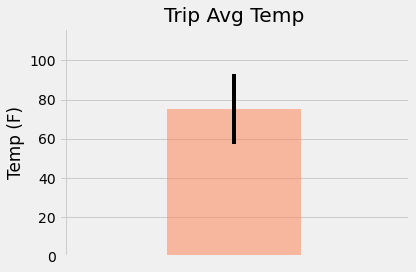

In [11]:
# Plot the results as a bar chart 
error = tmax-tmin
fig, ax = plt.subplots()
ax.bar(1, tavg, yerr=error, alpha=.5, color='coral', align='center')
ax.set(xticks=range(1), xticklabels=[], title='Trip Avg Temp', ylabel='Temp (F)')
ax.margins(.8, .25)
plt.tight_layout()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates
# Sort in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start = '2017-05-23'
end = '2017-05-28'

session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

[(3.9899999999999998, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (1.28, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (1.1600000000000001, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (0.64, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (0.39, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.30000000000000004, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

### Daily Temperature Normals

In [13]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [14]:
# Calculate the daily normals for your trip
start_date = dt.date(2017, 5, 23)
end_date = dt.date(2017, 5, 30)

# Use the start and end date to create a range of dates
delta = end_date - start_date
dates = [(start_date + dt.timedelta(days=i)).isoformat() for i in range(delta.days + 1)]
# Strip off the year and save a list of strings in the format of %m-%d
dates = [dt.date.fromisoformat(date).strftime('%m-%d') for date in dates]
# Use the `daily_normals` function to calculate the normals for each date string
normals = []

for date in dates:
    normals.append(daily_normals(date)[0])

normals

[(68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0)]

In [15]:
# Load the previous query results into a pandas dataframe and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = dates
df.set_index('date', inplace=True)

df

,tmin,tavg,tmax
date,,,
05-23,68.0,74.948276,87.0
05-24,67.0,73.948276,79.0
05-25,68.0,74.275862,79.0
05-26,65.0,74.036364,82.0
05-27,65.0,74.490909,80.0
05-28,67.0,74.277778,82.0
05-29,64.0,74.196078,80.0
05-30,69.0,74.333333,81.0


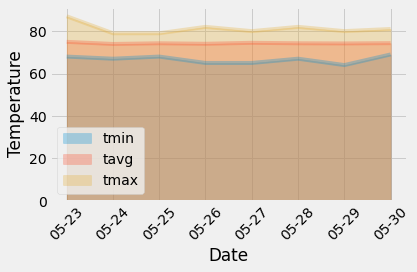

In [16]:
# Plot the daily normas as an area plot with `stacked=False`
df.plot.area(stacked=False, alpha=0.3, xlabel='Date', ylabel='Temperature')
plt.xticks(rotation=45)
plt.tight_layout()

### Close Sesssion

In [17]:
session.close()